In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

import dmslogo
import palettable
import dmslogo.colorschemes
from dmslogo.colorschemes import CBPALETTE

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT, N_value=0.25):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = N_value
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def decor_print(string):
    decor = 15*'-'
    print('', flush=True)
    print(decor + ' ' + string + ' ' + decor, flush=True)
    print('', flush=True)

    
def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        #base_thetas = theta_factor / 3 * torch.ones_like(target_thetas)
        line_gradients = []
        for i in range(0, num_steps + 1):
            point_thetas = (i / num_steps * target_thetas)
            #point_thetas = base_thetas + i / num_steps * (target_thetas - base_thetas)
            point_distributions = F.softmax(point_thetas, dim=-2)

            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for i in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)

            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas)
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()

def plot_variant_effects(effect_array, colors=['g', 'C1', 'r', 'b'], figsize=(50,5), stem_offset=0.0,
                         marker_alpha=0.5, stem_alpha=0.5, linestyle='solid', ax=None):
    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    plt.figure(figsize=figsize)
    
    offset = 0
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        #markerline, stemlines, baseline = plt.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i])
        markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        
        offset += stem_offset
    plt.margins(x=0.0075)
    plt.axis('off')
    return markerline, stemlines, baseline

def plot_mean_effect(effect_array, figsize=(50,5), color='k', markerfmt=','):
    sum_effects =  - effect_array.sum(axis=0)
    plt.figure(figsize=figsize)
    locs = np.arange(0, len(sum_effects))
    markerline, stemlines, baseline = plt.stem(locs, sum_effects, color, markerfmt=markerfmt)
    
def plot_satmut(ref_sequence_str, effect_array, lfcSE_array=None, ref_lfcSE=None, colors=['g', 'C1', 'r', 'b'], figsize=(50,5),
                         marker_alpha=1., stem_alpha=0.5, linestyle='dashed', ax=None):
    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))
    
    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        
        #offset += 0.1
    plt.margins(x=0.0075)
    
    effect_means = - effect_array.sum(axis=0) / 3.0
        
    if lfcSE_array is not None and ref_lfcSE is not None:
        lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
        alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
        shade_color_col='color'
        shade_alpha_col='shade'
    else:
        alphas = np.empty(effect_means.shape[0])
        alphas[:] = np.nan
        shade_color_col=None
        shade_alpha_col=None
    
    temp_data = [list(ref_sequence_str), effect_means, alphas]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height', 'shade']
    
    temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
    temp_df['site'] = temp_df.index
    
    y_max = max(effect_array.max(), effect_means.max()) + 0.1
    y_min = min(effect_array.min(), effect_means.min()) - 0.1
    
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            shade_color_col=shade_color_col,
                            shade_alpha_col=shade_alpha_col,
                            hide_axis=True,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)
    plt.show()
    
def plot_complete_contributions(ref_sequence_str, contributions_array, colors=['g', 'C1', 'r', 'b'], figsize=(50,5),
                         marker_alpha=1., stem_alpha=0.5, linestyle='dashed', ax=None):
    ref_array = utils.dna2tensor(ref_sequence_str).numpy()
    effect_array = (np.ones_like(ref_array) - ref_array) * contributions_array
      
    markerfmts = [color + 'o' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=(50,5))
    
    offset = 0.5
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        #plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.2)
        plt.setp(baseline, 'linestyle', 'dashed')
        
        #offset += 0.1
    plt.margins(x=0.0075)
    
    effect_means = - effect_array.sum(axis=0) / 3.0
    
    temp_data = [list(ref_sequence_str), effect_means]
    temp_df = pd.DataFrame(temp_data).transpose()
    temp_df.columns = ['letter', 'height']
    
    temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
    temp_df['site'] = temp_df.index
    
    y_max = max(effect_array.max(), effect_means.max()) + 0.1
    y_min = min(effect_array.min(), effect_means.min()) - 0.1
    
    fig, ax = dmslogo.draw_logo(data=temp_df,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='height',
                            color_col='color',
                            hide_axis=True,
                            fixed_ymax=y_max,
                            fixed_ymin=y_min,
                            ax=ax)
    plt.show()

# Tewhey lab SatMut

In [4]:
satmut_df = pd.read_csv('gs://syrgoth/data/saturation_mutagenesis/DNM_sknsh_with_seqs.txt', sep='\t')

df_temp = satmut_df[(satmut_df.Project != 'negCtrl') &  (satmut_df.Project != 'posCtrl')].reset_index(drop=True)

In [5]:
#In-vitro saturation mutagenesis
regions = [snp for snp in sorted(set(df_temp.SNP)) if '-' in snp]

effect_tensor_dict = {}
for region in regions:
    region_df = df_temp[(df_temp.SNP == region) & (df_temp.strand == 'fwd')]
    ref_sequence_df = region_df[region_df['Row.names'] == region_df['SNP']]
    if len(ref_sequence_df) == 1:
        print(region)
        num_variants = len(set(region_df['Row.names'])) - 1
        ref_id = ref_sequence_df['Row.names'].values[0]
        ref_sequence = ref_sequence_df['nt_sequence'].values[0]
        ref_lfc = float(ref_sequence_df['log2FoldChange'])
        ref_lfcSE = float(ref_sequence_df['lfcSE'])

        effect_tensor = torch.zeros((4, len(ref_sequence)))
        lfcSE_tensor = torch.zeros((4, len(ref_sequence)))
        for idx, row in region_df.iterrows():
            alt_id = row['Row.names']
            if alt_id != ref_id:
                mutation_info = alt_id.split(':')[-1]
                ref_base = mutation_info[0]
                alt_base = mutation_info[-1]
                site_idx = int(mutation_info[1:-1]) - 1        
                alt_lfc = row['log2FoldChange']
                alt_lfcSE = row['lfcSE']
                effect_tensor[constants.STANDARD_NT.index(alt_base), site_idx] = alt_lfc - ref_lfc
                lfcSE_tensor[constants.STANDARD_NT.index(alt_base), site_idx] = alt_lfcSE
        effect_tensor_dict[region] = {'ref_sequence': ref_sequence,
                                      'ref_lfc': ref_lfc,
                                      'ref_lfcSE': ref_lfcSE,
                                      'mpra_effect': effect_tensor,
                                      'num_mpra_alts': num_variants,
                                      'lfcSE_tensor': lfcSE_tensor
                                     }

chr14:29859932-29860132
chr14:37559109-37559309
chr14:57553315-57553515
chr17:2095085-2095285
chr17:2095258-2095458
chr19:30843409-30843609
chr1:47041104-47041304
chr1:90847872-90848072
chr2:60077721-60077921
chr3:136760181-136760381
chr3:19028436-19028636
chr4:147215670-147215870
chr5:87852766-87852966
chr6:136595273-136595473
chr6:14501550-14501750
chr6:91342117-91342317
chr7:100480515-100480715
chr7:114999468-114999668
chr7:114999561-114999761


In [6]:
#Contribution scores
cell_type = 2
dual_pred = False
eval_batch_size = 1040

predictor = mpra_predictor(model=model, pred_idx=cell_type, dual_pred=dual_pred).cuda()

batch_tensor = torch.stack([utils.dna2tensor(dicti['ref_sequence']) for dicti in effect_tensor_dict.values()])
salient_maps, extended_contributions = isg_contributions(batch_tensor, predictor, eval_batch_size=eval_batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
#In-silico saturation mutagenesis
# dual_pred = True
# predictor = mpra_predictor(model=model, pred_idx=cell_type, dual_pred=dual_pred).cuda()

all_ref_sequences = [dicti['ref_sequence'] for dicti in effect_tensor_dict.values()]

ref_predictions = []
predicted_saturations = []
for sequence_as_string in tqdm(all_ref_sequences):
    combinations = []
    for idx in range(len(sequence_as_string)):
        four_combinations = torch.stack([utils.dna2tensor(sequence_as_string[:idx] + base + sequence_as_string[idx+1:]) for base in constants.STANDARD_NT])
        combinations.append(four_combinations)
    combinations = torch.stack(combinations).flatten(0,1)
    
    ref_tensor = utils.dna2tensor(sequence_as_string)
    base_prediction = predictor(ref_tensor.view(1,4,-1).cuda()).detach().cpu()
    sat_preds = predictor(combinations.cuda()).detach().cpu()
    
    out_tensor = (sat_preds.unflatten(0, (200, 4)).T - base_prediction) * (torch.ones_like(ref_tensor) - ref_tensor)
    predicted_saturations.append(out_tensor)
    ref_predictions.append(base_prediction.item())

  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
### Add in-silico and contributions to dicts
for idx, dicti in enumerate(effect_tensor_dict.values()):
    dicti['salient_maps'] = salient_maps[idx, ...].detach().numpy()
    dicti['extended_contributions'] = extended_contributions[idx, ...].detach().numpy()
    dicti['ref_pred'] = ref_predictions[idx]
    dicti['pred_effect'] = predicted_saturations[idx].numpy()

In [9]:
### Order dict keys by log2FC
dict_by_lfc = {}
dict_by_idx = {}
for idx, key in enumerate(effect_tensor_dict.keys()):
    print(idx, key)
    dict_by_lfc[key] = float(effect_tensor_dict[key]['ref_lfc'])
    dict_by_idx[key] = idx
dict_by_lfc = dict(sorted(dict_by_lfc.items(), key = lambda item: item[1], reverse=True))

0 chr14:29859932-29860132
1 chr14:37559109-37559309
2 chr14:57553315-57553515
3 chr17:2095085-2095285
4 chr17:2095258-2095458
5 chr19:30843409-30843609
6 chr1:47041104-47041304
7 chr1:90847872-90848072
8 chr2:60077721-60077921
9 chr3:136760181-136760381
10 chr3:19028436-19028636
11 chr4:147215670-147215870
12 chr5:87852766-87852966
13 chr6:136595273-136595473
14 chr6:14501550-14501750
15 chr6:91342117-91342317
16 chr7:100480515-100480715
17 chr7:114999468-114999668
18 chr7:114999561-114999761


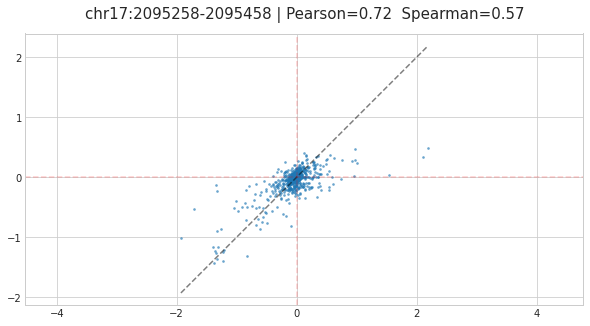

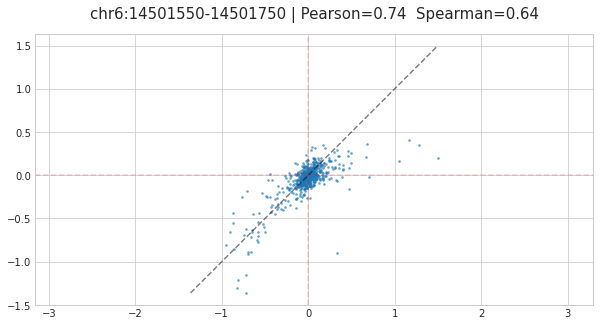

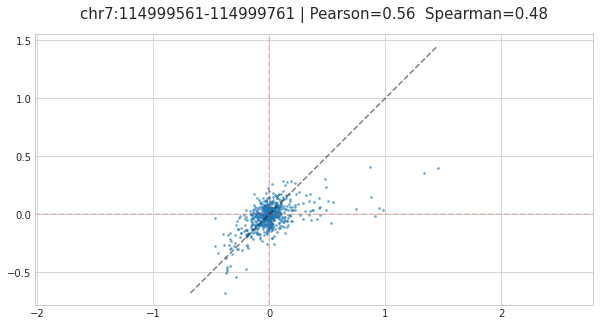

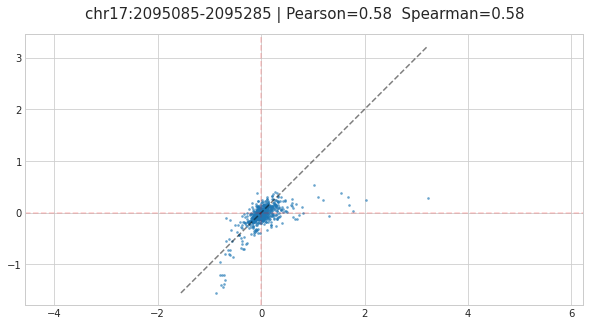

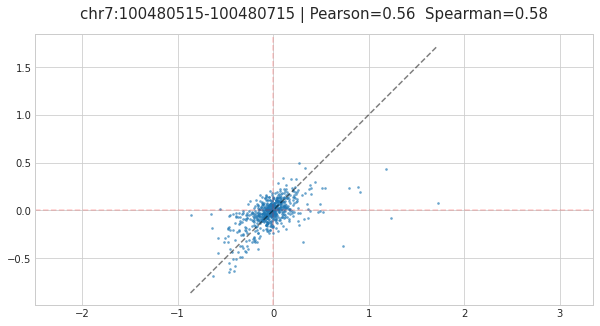

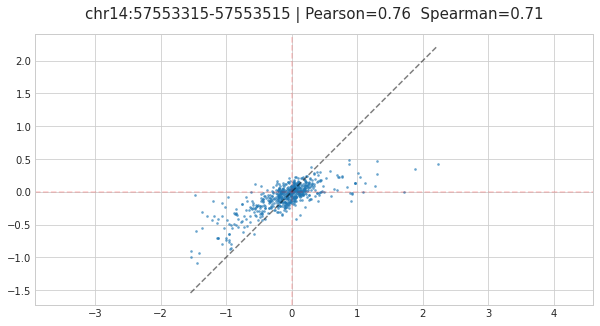

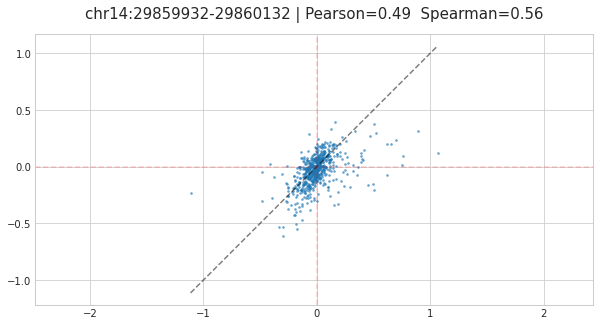

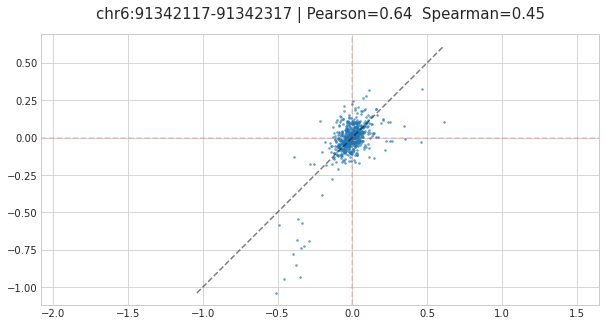

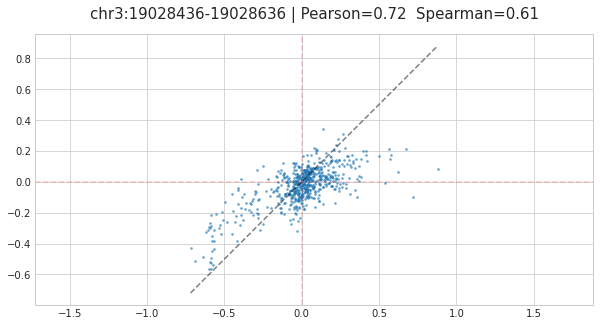

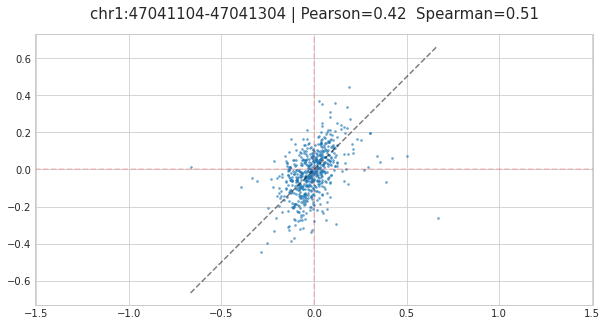

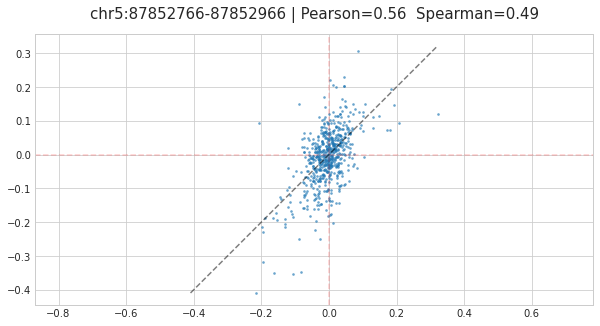

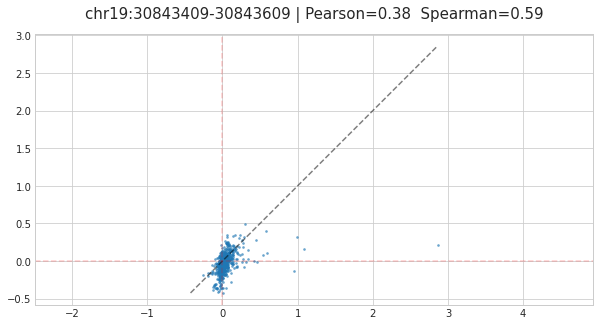

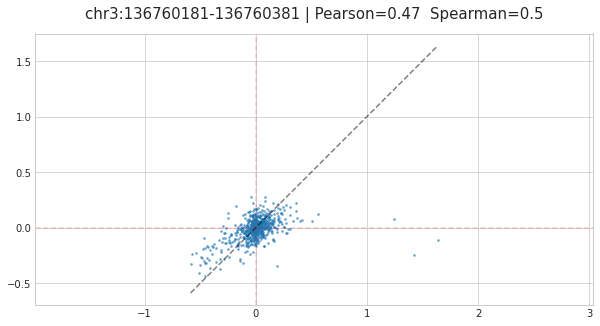

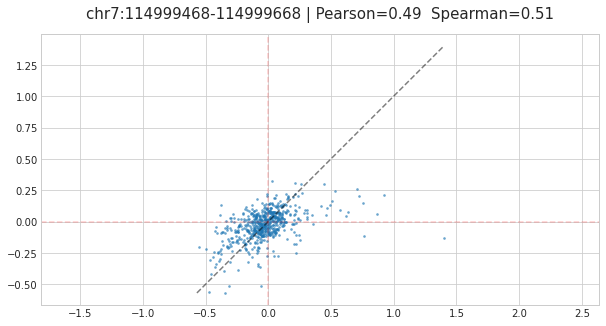

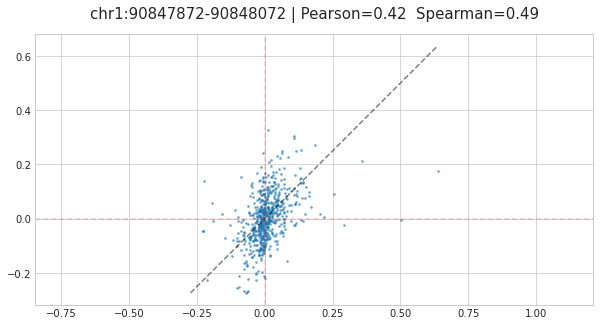

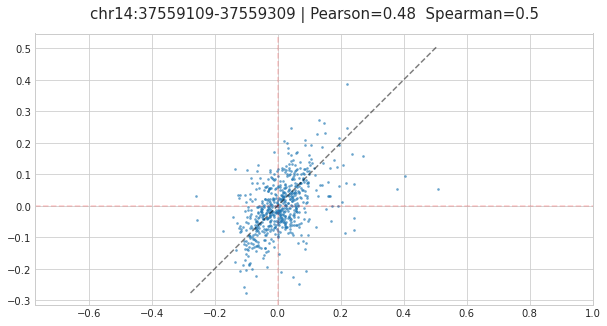

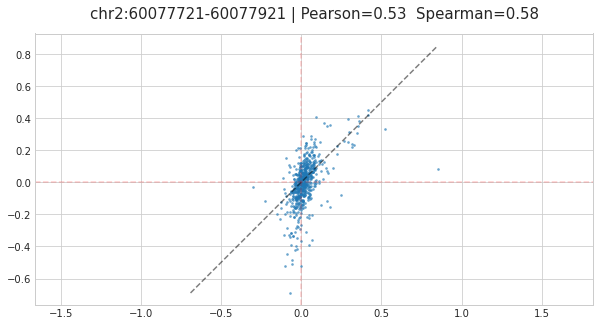

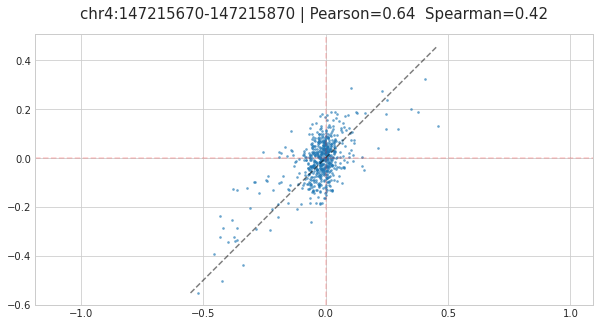

In [28]:
save_figures = False
for key in dict_by_lfc.keys():
    #idx = dict_by_idx[key]
    tensor_dict = effect_tensor_dict[key]
    
    num_variants = tensor_dict['num_mpra_alts']    
    if num_variants == 600:
        ref_sequence = tensor_dict['ref_sequence']
        ref_lfc = tensor_dict['ref_lfc']
        effect_array = tensor_dict['mpra_effect'].numpy()
        lfcSE_array = tensor_dict['lfcSE_tensor'].numpy()

        effect_means = - effect_array.sum(axis=0) / 3.0
        lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
        ref_lfcSE = tensor_dict['ref_lfcSE']
        lfcSE_maxs = lfcSE_array.max(axis=0)
        
        pred_effect_array = tensor_dict['pred_effect']
        pred_effect_means = - pred_effect_array.sum(axis=0) / 3.0
        pred_lfc = round(tensor_dict['ref_pred'], 4)
        
        one_hot_sequence = utils.dna2tensor(ref_sequence)
        opp_one_hot_sequence = torch.ones_like(one_hot_sequence) - one_hot_sequence
        salient_map = tensor_dict['salient_maps']
        extended_contributions = tensor_dict['extended_contributions']
        #contri_effects = extended_contributions - salient_map
        normal_extended_contributions = extended_contributions - extended_contributions.mean(axis=0)
        contri_effects = normal_extended_contributions * opp_one_hot_sequence.numpy()
        contri_effects = 8 * contri_effects
        #contri_effects = extended_contributions - np.repeat(salient_map.sum(axis=0)[np.newaxis,:], 4, axis=0) #* np.sign(extended_contributions)
        
        #a, b = effect_array.flatten(), contri_effects.flatten() 
        #a, b = effect_array.flatten(), pred_effect_array.flatten()
        a, b = pred_effect_array.flatten(), contri_effects.flatten() 
        position_filter = np.nonzero(a)
        a, b = a[position_filter], b[position_filter]
        pearson = round(np.corrcoef(a, b)[0,1], 2)
        spearman = round(stats.spearmanr(a, b)[0], 2)
        
        #print(f'{key} | ref lfc: {round(ref_lfc, 4)} | pred lfc: {pred_lfc} | ref lfcSE: {round(ref_lfcSE, 4)} | Pearson: {pearson}')
        
        with plt.style.context('seaborn-whitegrid'):
            plt.figure(figsize=(10,5))
            
            #colors = np.maximum(lfcSE_array[position_filter], ref_lfcSE[position_filter] * np.ones_like(lfcSE_array[position_filter]))
            #colors = np.maximum(lfcSE_maxs, ref_lfcSE * np.ones_like(lfcSE_means))
            cm = plt.cm.get_cmap('summer')

            plt.scatter(a, b, alpha=0.5, marker='.', s=12.0)
            #plt.scatter(a, b, alpha=0.5, c=colors, cmap=cm, marker='.', s=12.0)
            #plt.colorbar(label='lfcSE')
            #plt.clim(0, 1.5) 

            x_min, y_min = a.min(), b.min()
            x_max, y_max = a.max(), b.max()
            min_point, max_point = min(x_min, y_min), max(x_max, y_max)
            plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)
            plt.axhline(0, color='red', alpha=0.2, linestyle='--') # x = 0
            plt.axvline(0, color='red', alpha=0.2, linestyle='--') # y = 0
            plt.axis('equal')
            plt.title(f'{key} | Pearson={pearson}  Spearman={spearman}', fontsize=15, pad=15, fontweight='medium')
#             plt.xlabel('Experimental effect', fontsize=16)
#             plt.ylabel('Predicted effect', fontsize=16)
            fig_path = 'figures/' + f'{key}_scatter' + '.png'
            if save_figures:
                plt.savefig(fig_path, transparent=True )
            plt.show()

#             plot_variant_effects(effect_array)
#             plt.title('In-vitro', fontsize=32)
#             fig_path = 'figures/' + f'{key}_invitro' + '.png'
#             if save_figures:
#                 plt.savefig(fig_path, transparent=True )
#             plt.show()
#             plot_variant_effects(pred_effect_array)
#             plt.title('In-silico', fontsize=32)
#             fig_path = 'figures/' + f'{key}_insilico_{str(pearson)}_{str(spearman)}' + '.png'
#             if save_figures:
#                 plt.savefig(fig_path, transparent=True )
#             plt.show()
            